In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [152]:
df = pd.read_csv('hms-harmful-brain-activity-classification/train.csv')

In [153]:
df.head(15)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [155]:
print(df['eeg_id'].nunique())
print(df['patient_id'].nunique())

17089
1950


- Should we split the data by patient_id for eeg_id?
- is this data leaking if I do by eeg_id?

In [156]:
# df[df['patient_id']==56885]
df.groupby('patient_id')['expert_consensus'].nunique().value_counts()

expert_consensus
1    854
2    694
3    271
4     93
5     30
6      8
Name: count, dtype: int64

In [157]:
df['eeg_id'].value_counts()

eeg_id
2259539799    743
2428433259    664
1641054670    562
2860052642    534
525664301     531
             ... 
3115575521      1
3218602720      1
3851517872      1
3042198969      1
3009745953      1
Name: count, Length: 17089, dtype: int64

In [158]:
df['eeg_id'].unique()

array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
        351917269])

In [159]:
df.groupby('eeg_id')['expert_consensus'].nunique().value_counts()

expert_consensus
1    16306
2      666
3       94
4       22
5        1
Name: count, dtype: int64

- the same eeg sometimes seem to have multiple expert consensus result.

In [160]:
count = 0
amb_list = []

for id in df['eeg_id'].unique():
    if df[df['eeg_id']==id]['expert_consensus'].nunique() != 1:
        count += 1
        amb_list.append(id)
        #print(id)

print('the number of patients with multiple expert consensus is', count)

the number of patients with multiple expert consensus is 783


In [161]:
#amb_list
#df[df['eeg_id']==amb_list[0]]

In [162]:
# examples on eeg_id with multiple expert consensus 2578018731, 2521925389

print(df[df['eeg_id']==2578018731]['expert_consensus'].value_counts())
print('\n')
print(df[df['eeg_id']==2521925389]['expert_consensus'].value_counts())

expert_consensus
GRDA     3
Other    1
Name: count, dtype: int64


expert_consensus
LPD        22
Seizure    10
Other       2
Name: count, dtype: int64


- I will remove these cases for now and we can return to them later

In [163]:
unique_votes = df['eeg_id'].apply(lambda x: df[df['eeg_id']==x]['expert_consensus'].nunique())

In [164]:
df['unique_votes'] = unique_votes
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,unique_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,1
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,1
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,1
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,1
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,1


In [165]:
unamb_df = df[df['unique_votes']==1]
unamb_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,unique_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,1
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,1
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,1
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,1
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,1


In [166]:
len(unamb_df)

93956

In [167]:
unamb_df['eeg_id'].nunique()

16306

- we can split the data using the 'unique' ids in this unamb_df

In [168]:
unamb_df['eeg_id'].unique()

array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
        351917269])

In [169]:
unamb_df.groupby('eeg_id')['expert_consensus'].agg(pd.Series.mode)

eeg_id
568657        Other
582999          LPD
642382        Other
751790          GPD
778705        Other
              ...  
4293354003     GRDA
4293843368     GRDA
4294455489    Other
4294858825    Other
4294958358    Other
Name: expert_consensus, Length: 16306, dtype: object

<Axes: xlabel='expert_consensus', ylabel='count'>

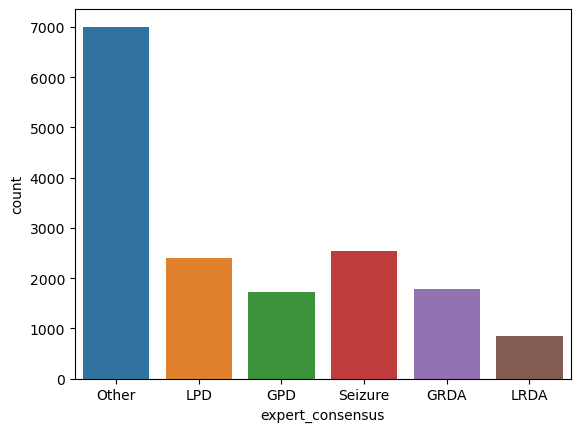

In [170]:
sns.countplot(x=unamb_df.groupby('eeg_id')['expert_consensus'].agg(pd.Series.mode))

<Axes: xlabel='expert_consensus', ylabel='count'>

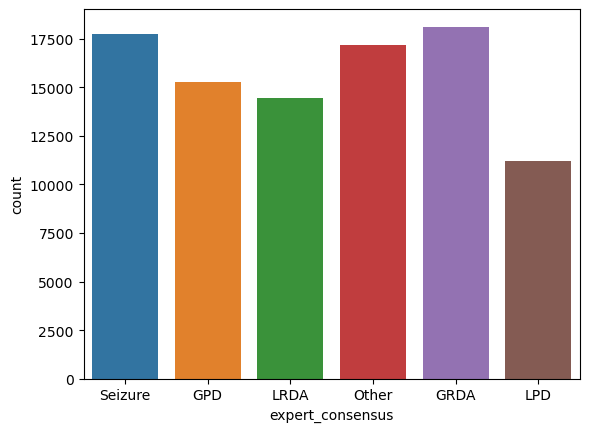

In [171]:
sns.countplot(x=unamb_df['expert_consensus'])

 - the test.csv file has only one test data point
 - the train folder has about 100k data pts
 - unamb_df still has about 93K pts
 - below we split the train data into 3 parts - train_df(64%), val_df(16%), test_df(20%)

In [172]:
from sklearn.model_selection import train_test_split

In [173]:
unamb_ids = unamb_df['eeg_id'].unique()
unamb_ids

array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
        351917269])

In [174]:
# Split the data into a training set and a test set
# Choosing random seed = 42

train_val_ids, test_ids = train_test_split(unamb_ids, test_size=0.20, random_state=42)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.20, random_state=42)

In [175]:
train_ids

array([1704746065, 1058584796, 2380136004, ..., 1799193939, 3771606798,
       2101809798])